In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
import os
from PIL import Image
import time

In [16]:
class ModifiedCheXNet(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedCheXNet, self).__init__()
        self.base_model = models.densenet121(pretrained=True)
        num_features = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

In [17]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label


In [18]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the number of classes
num_classes = 9

# Set the paths and filenames
data_csv_file = 'Hierarchy_sample.csv'
data_dir = 'images/'

In [19]:
# Set the batch size and number of epochs
batch_size = 32
num_epochs = 30


In [20]:
# Define the transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [21]:
# Create the dataset
dataset = CustomDataset(data_csv_file, data_dir, transform=transform)

In [22]:

# Split the dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create the train and test data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
# Create the model
model = ModifiedCheXNet(num_classes)
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

c:\Users\dell\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
avg_losses =[]

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    train_loss /= len(train_loader.dataset)
    accuracy = 100 * correct / total
    avg_losses.append(train_loss)
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}% and time : {elapsed_time:.2f}')

Epoch 1/30, Train Loss: 1.8717, Accuracy: 36.24% and time : 202.09
Epoch 2/30, Train Loss: 1.7554, Accuracy: 38.86% and time : 216.64
Epoch 3/30, Train Loss: 1.6853, Accuracy: 39.86% and time : 201.12
Epoch 4/30, Train Loss: 1.6173, Accuracy: 42.77% and time : 200.70
Epoch 5/30, Train Loss: 1.5576, Accuracy: 44.78% and time : 200.84
Epoch 6/30, Train Loss: 1.4664, Accuracy: 47.09% and time : 200.63
Epoch 7/30, Train Loss: 1.2756, Accuracy: 55.72% and time : 208.73
Epoch 8/30, Train Loss: 1.2387, Accuracy: 55.52% and time : 204.58
Epoch 9/30, Train Loss: 1.2793, Accuracy: 55.52% and time : 237.48
Epoch 10/30, Train Loss: 1.0223, Accuracy: 64.26% and time : 235.70
Epoch 11/30, Train Loss: 0.8106, Accuracy: 72.29% and time : 230.40
Epoch 12/30, Train Loss: 0.5355, Accuracy: 82.03% and time : 244.58
Epoch 13/30, Train Loss: 0.4329, Accuracy: 85.24% and time : 233.71
Epoch 14/30, Train Loss: 0.3107, Accuracy: 89.86% and time : 269.99
Epoch 15/30, Train Loss: 0.2260, Accuracy: 92.67% and tim

In [25]:
# Set the path and filename for saving the model
save_path = '../model3.pth'

# Save the model
torch.save(model.state_dict(), save_path)

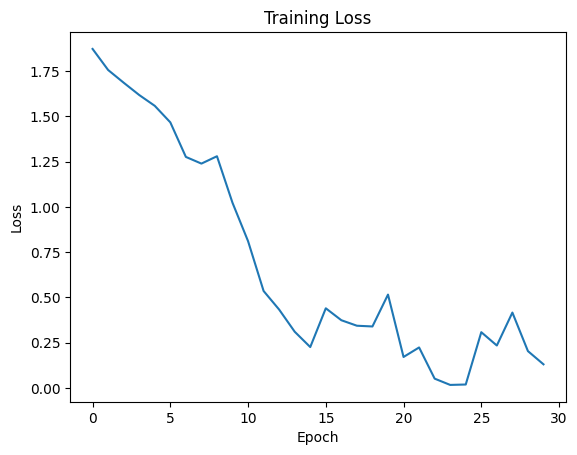

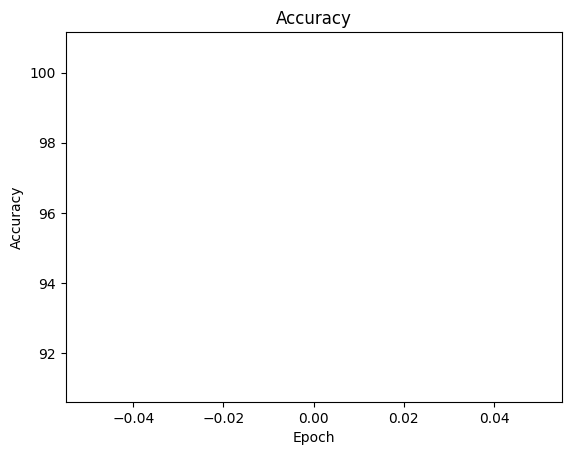

In [26]:
import matplotlib.pyplot as plt

# Plot the losses
plt.plot(avg_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

plt.plot(accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

In [27]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix

# Initialize empty lists to store predicted labels and true labels
predicted_labels = []
true_labels = []

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate F1 score and confusion matrix
f1 = f1_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print F1 score and confusion matrix
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].